In [4]:
import os, argparse, logging
import bfio
from bfio import BioReader

import numpy as np

from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import torchvision.models as models
from torch import Tensor
from typing import Union
import albumentations
from torch.nn.modules.loss import _Loss as TorchLoss

In [5]:
class LocalNorm(object):
    def __init__(
            self,
            window_size: int = 129,
            max_response: Union[int, float] = 6,
    ):
        assert window_size % 2 == 1, 'window_size must be an odd integer'

        self.window_size: int = window_size
        self.max_response: float = float(max_response)
        self.pad = torchvision.transforms.Pad(window_size // 2 + 1, padding_mode='reflect')
        # Mode can be 'test', 'train' or 'eval'.
        self.mode: str = 'eval'

    def __call__(self, x: Tensor):
        return torch.clip(
            self.local_response(self.pad(x)),
            min=-self.max_response,
            max=self.max_response,
        )

    def image_filter(self, image: Tensor) -> Tensor:
        """ Use a box filter on a stack of images
        This method applies a box filter to an image. The input is assumed to be a
        4D array, and should be pre-padded. The output will be smaller by
        window_size - 1 pixels in both width and height since this filter does not pad
        the input to account for filtering.
        """
        integral_image: Tensor = image.cumsum(dim=-1).cumsum(dim=-2)
        return (
                integral_image[..., :-self.window_size - 1, :-self.window_size - 1]
                + integral_image[..., self.window_size:-1, self.window_size:-1]
                - integral_image[..., self.window_size:-1, :-self.window_size - 1]
                - integral_image[..., :-self.window_size - 1, self.window_size:-1]
        )

    def local_response(self, image: Tensor):
        """ Regional normalization.
        This method normalizes each pixel using the mean and standard deviation of
        all pixels within the window_size. The window_size parameter should be
        2 * radius + 1 of the desired region of pixels to normalize by. The image should
        be padded by window_size // 2 on each side.
        """
        local_mean: Tensor = self.image_filter(image) / (self.window_size ** 2)
        local_mean_square: Tensor = self.image_filter(image.pow(2)) / (self.window_size ** 2)

        # Use absolute difference because sometimes error causes negative values
        local_std = torch.clip(
            (local_mean_square - local_mean.pow(2)).abs().sqrt(),
            min=1e-3,
        )

        min_i, max_i = self.window_size // 2, -self.window_size // 2 - 1
        response = image[..., min_i:max_i, min_i:max_i]

        return (response - local_mean) / local_std



In [26]:
modelpath = "output_SMP" + \
"/Unet-MCCLoss-resnet18-random-Adadelta-binary-HorizontalFlip_ShiftScaleRotate_PadIfNeeded_RandomCrop_GaussianNoise_Perspective_RandomBrightnessContrast_RandomGamma_Sharpen_Blur_MotionBlur-NA/" + \
"checkpoint.pth"
# imagepath = "/home/vihanimm/SegmentationModelToolkit/Data/tif_data/nuclear/validation/image_subset/nuclear_validation_967.tif"
# labelpath = "/home/vihanimm/SegmentationModelToolkit/Data/tif_data/nuclear/validation/groundtruth_centerbinary_subset/nuclear_validation_967.tif"
imagedir = "/home/vihanimm/SegmentationModelToolkit/Data/tif_data/nuclear/validation/image_subset/"
labeldir = "/home/vihanimm/SegmentationModelToolkit/Data/tif_data/nuclear/validation/groundtruth_centerbinary_subset/"

(256, 256)
0.1752256 0.99996793


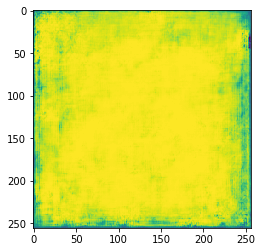

java.io.FileNotFoundException: java.io.FileNotFoundException: /home/vihanimm/SegmentationModelToolkit/Data/tif_data/nuclear/validation/groundtruth_centerbinary_subset (Is a directory)

In [29]:
MODELS = {
    'Unet': smp.Unet,
    'UnetPlusPlus': smp.UnetPlusPlus,
    'MAnet': smp.MAnet,
    'Linknet': smp.Linknet,
    'FPN': smp.FPN,
    'PSPNet': smp.PSPNet,
    'PAN': smp.PAN,
    'DeepLabV3': smp.DeepLabV3,
    'DeepLabV3Plus': smp.DeepLabV3Plus,
}

import torchvision
modelparameters = torch.load(modelpath)
model = MODELS[modelparameters["model_name"]](
    encoder_name=modelparameters["encoder_variant"],
    encoder_weights=modelparameters["encoder_weights"],
    in_channels=1,
    activation='sigmoid'
)
model.eval()

imagedir_list = os.listdir(imagedir)
labeldir_list = os.listdir(labeldir)

iou_score_eqn = smp.utils.metrics.IoU(activation='sigmoid')

for imagepath, labelpath in zip(imagedir_list, labeldir_list):
    assert imagepath == labelpath
    imagepath = os.path.join(imagedir, imagepath)
    labelpath = os.path.join(labeldir, labelpath)

    preprocessing = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),LocalNorm()])
    augmentations = []
    with BioReader(imagepath, backend="java") as br_imgobj:
        br_imgarr = br_imgobj[:]
        br_imgarr = np.reshape(br_imgarr, (1, 256, 256))

        transform = albumentations.Compose(augmentations)
        sample = transform(image=br_imgarr)
        
        image = sample['image'].squeeze()
        preprocessedimage = preprocessing(image).numpy()
        br_tensor = torch.from_numpy(preprocessedimage).to('cpu').unsqueeze(0)
        output_tensor = model.predict(br_tensor)
        output_image = output_tensor.numpy().squeeze()
        print(output_image.shape)
        
        print(np.min(output_image), np.max(output_image))
        plt.imshow(output_image)
        plt.show()

    with BioReader(labelpath, backend="java") as br_labobj:
        br_labarr = br_labobj[:]
        br_labarr[br_labarr > 0] = 1
        predict_tensor = torch.from_numpy(br_labarr).to('cpu').unsqueeze(0)
        plt.imshow(br_labarr)
        plt.show()
        

    iou_score = iou_score_eqn.forward(y_pr = output_tensor, y_gt = predict_tensor)
    print(iou_score)


tensor(0.3228)
